# How to Build a **Recommender System** from Scratch

## By [Jill Cates](https://www.jillcates.com/pydata-workshop/html/tutorial.html)


Source/Links:  
+ Jill Cates [Recommender Systems 101](https://medium.com/@topspinj/recommender-systems-101-bcbdfbe1e6e7)
+

# Agenda

1. What is a recommender system?
1. Why do we need recommender systems?
1. How does it work?
1. Collaborative Filtering
1. Content-based Filtering
1. Tutorial using MovieLens dataset

# What is a Recommender System?

- an application of machine learning
- predicts a user's preference towards a given item
- aims to drive user engagement

<h1 style="text-align:center">Why Do We Need Recommender Systems?</h1>

The [Tasting Booth Experiment](https://faculty.washington.edu/jdb/345/345%20Articles/Iyengar%20%26%20Lepper%20(2000).pdf) (Iyengar and Lepper, 2000)

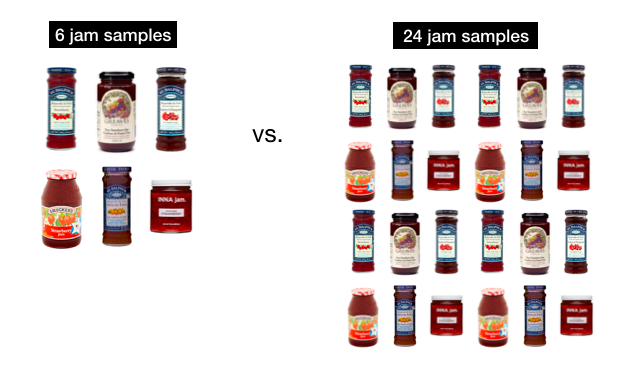

<p style="text-align:center;">"30% of the consumers in the limited-choice condition subsequently purchased a jar of jam; in contrast, only 3% of the consumers in the extensive-choice condition did so"</p>

---
# **Collaborative** Filtering

- Based on the assumption that similar users like similar things
- "Customers who bought this item also bought..."
- "Because you watched Movie X..."

<p style="text-align:center;">User-item ("utility") matrix</p>

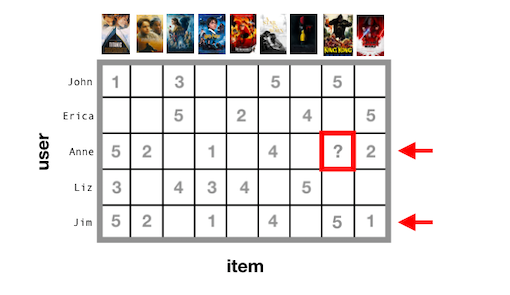

# **Content-based** Filtering

- Generates recommendations using user and item features
- Handles the cold-start problem for new users and items
- User features: `age`, `gender`, `spoken language`
- Item features: `movie genre`, `year of release`, `cast`

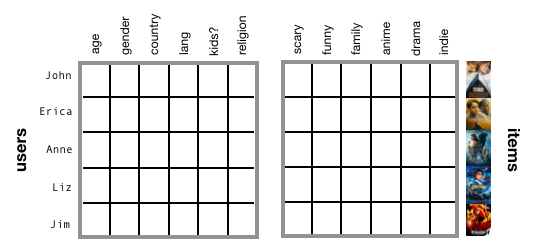

---  
# Tutorial

Build an item-item recommender using the [**MovieLens**](https://movielens.org/) dataset curated by [GroupLens](https://grouplens.org/)  a research lab in the Department of Computer Science and Engineering at the University of Minnesota, T specializing in recommender systems, online communities, mobile and ubiquitous technologies, digital libraries, and local geographic information systems.

- Small: 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9/2018
- Full: approximately 33,000,000 ratings and 2,000,000 tag applications applied to 86,000 movies by 330,975 users. Includes tag genome data with 14 million relevance scores across 1,100 tags. Last updated 9/2018.



# Step 1: Import Dependencies

<p style="margin-bottom:0;">We will be representing our data as a <b>Pandas DataFrame</b>.</p>

- a two-dimensional data structure
- `columns` represent features, `rows` represent items
- analogous to an Excel spreadsheet or SQL table
- documentation can be found here

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

# Step 2: Load the Data

- Download the dataset from MovieLens [here](https://grouplens.org/datasets/movielens/)
- Consists of two files:
    - `ratings.csv`
    - `movies.csv`
- These files can also be accessed directly with these links:
    - https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv
    - https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv

### Ratings

<p style="margin-bottom:0;">Dataframe contains 4 columns:</p>

- `userId`
- `movieId`
- `rating`
- `timestamp`

We need this data to perform collaborative filtering.

In [3]:
ratings = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv")

ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Movies

<p style="margin-bottom:0;">Dataframe contains 3 columns:</p>

- `movieId`
- `title`
- `genres`

We need this data to interpret the results of our collaborative filtering recommender.



In [4]:
movies = pd.read_csv("https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv")

movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


# Step 3: Exploratory Data Analysis

`Ratings` contains users' ratings for a given movie. Let's see how many ratings, unique movies, and unique users are in our dataset.

In [5]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

In [5]:
print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


<p style="margin-bottom:0;"> How many ratings did each user make? Let's use pandas' groupby() and count() to:</p>

1. group the data by userId's
2. count the number of ratings for each userId.

In [6]:
user_freq = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
user_freq.head()

,userId,n_ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


In [7]:
mean_n_ratings = user_freq['n_ratings'].mean()
print(f"Mean number of ratings for a given user: {mean_n_ratings:.2f}.")

Mean number of ratings for a given user: 165.30.


Let's visualize the distribution of movie ratings in this dataset, and distribution of user rating frequency. We can do this using a Python package called [seaborn](https://seaborn.pydata.org/).

<ipython-input-8-b397337478eb>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="rating", data=ratings, palette="viridis")


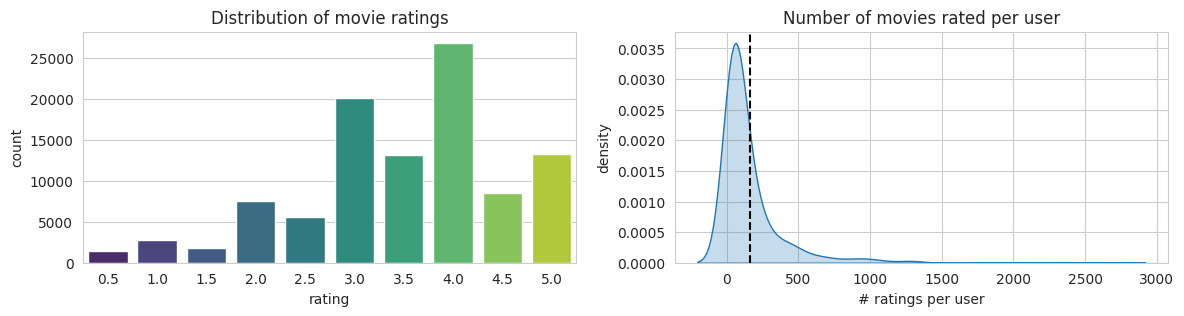

In [8]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,3))

# PLOT 1
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=ratings, palette="viridis")
ax.set(title="Distribution of movie ratings")

# PLOT 2
plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], fill=True, legend=False)

ax.set(title="Number of movies rated per user", xlabel="# ratings per user", ylabel="density")
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")

plt.show()

### What are the highest and lowest rated movies?

To find the "best" and "worst" movies, we need to calculate the mean rating for each movie in our dataset. We can do this by grouping by `movieId` and calculating the mean of the `rating` column.

In [9]:
mean_rating = ratings.groupby('movieId')[['rating']].mean()
mean_rating.head()

,rating
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429


### What are the highest and lowest rated movies?

In [10]:
lowest_rated = mean_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [11]:
highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


<img src="images/lamerica.png" align="right" width="15%"/>

### The highest rated movie is Lamerica?!

I'm sure that this movie is great but it doesn't sound like a familiar blockbuster. Let's dig deeper and see who rated this movie.

In [12]:
ratings.loc[ratings['movieId']==highest_rated]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


While Lamerica may have the "highest" average rating, it only received 2 ratings. This isn't a good measure of a movie's popularity. The quality of a movie's rating depends not only on the average rating but also on the number of ratings.

# Bayesian Average

- A weighted average that accounts for how many ratings there are
- Useful when there isn't much data available
- Used extensively in baseball statistics (i.e., batting average)
- Calculate with the following equation:

$$r_{i} = \frac{C \times m + \Sigma{\text{ratings}}}{C+N} $$

<p style="margin-bottom:0;">where:</p>

- $C$ = our confidence (average number of ratings for a given movie)
- $m$ = our prior (global average rating)
- $N$ = total number of ratings for movie $i$

We first need to get the `count` and `mean` for each movie in our dataset. We can do this with a sophisticated `groupby` that applies both `mean` and `count` using the `agg` method.

In [13]:
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


Let's calculate the Bayesian average. We first write a function that computes the Bayesian average for a given movie.

In [14]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings_i):
    bayesian_avg = (C*m+ratings_i.sum())/(C+ratings_i.count())
    return bayesian_avg

We can apply `bayesian_avg` to our entire ratings dataset using the `agg` method.

In [15]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']

bayesian_avg_ratings.head()

,movieId,bayesian_avg
0,1,3.890632
1,2,3.417227
2,3,3.260086
3,4,2.897612
4,5,3.104793


Which movies have the highest Bayesian average rating?

In [16]:
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')
movie_stats = movie_stats.merge(movies[['movieId', 'title']])

movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392070,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236457,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227052,Fight Club (1999)
224,260,251,4.231076,4.192646,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.190567,"Usual Suspects, The (1995)"


Using Bayesian averages, we can see that Lamerica is no longer the top movie.

Which movies have the lowest Bayesian average rating?

In [17]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190377,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224426,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267268,Godzilla (1998)
1144,1499,27,1.925926,2.296800,Anaconda (1997)
1988,2643,16,1.687500,2.306841,Superman IV: The Quest for Peace (1987)


# Step 4: Transforming the Data

- Need to transform data into user-item matrix for collaborative filtering
- [scipy.sparse_matrix](https://docs.scipy.org/doc/scipy/reference/sparse.html): columns are movies and rows are users
- Each cell is populated with a user's rating towards a movie
- Empty cell = no rating available

<img src="images/utility-matrix.png" width=70%/>

In [18]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from the ratings dataframe.

    Args:
        df: ratings dataframe

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))

    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))

    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [19]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper =create_X(ratings)

### Calculating Sparsity of the Matrix

Let's see how sparse our matrix, $X$, is. We can calculate matrix density, $d$, with the following equation:

$d=\frac{\text{# non-zero elements}}{\text{total # elements}}$

In [30]:
density = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Matrix density: {round(density*100,2)}%")

Matrix density: 1.7%


Wow, our matrix is quite sparse. But don't be discouraged! User-item matrices are typically very sparse. A general rule of thumb is that your matrix density should be no lower than 0.5% to generate decent results.

### How to save your sparse matrix

To save our sparse matrix for future analysis, we can use scipy's sparse matrix `save_npz` [method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.save_npz.html).

In [24]:
from scipy.sparse import save_npz, load_npz

save_npz('user_item_matrix.npz', X)

We can load it again using `load_npz`.

In [28]:
X = load_npz('user_item_matrix.npz')

X

(9724, 610)

In [27]:
X.shape

(9724, 610)

# Step 5: Finding similar movies using k-Nearest Neighbours

k-Nearest Neighbours (kNN) is a classification algorithm that predicts the label of a given sample based on majority vote of its nearest $k$ neighbours.

Distance between two samples can be measured using `cosine similarity`, `Euclidean distance`, `Manhattan distance`, etc.

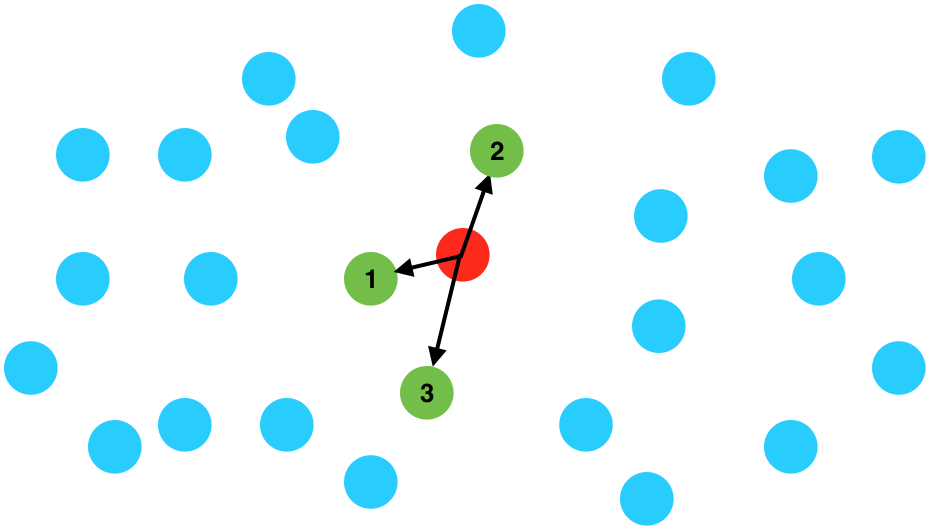

### Cosine Similarity vs. Euclidean Distance

- **Cosine Similarity**: measures similarity of two points in orientation (i.e., the cosine angle between $A$ and $B$)
    - the closer the cosine similarity is to 1, the more similar the items are

$$\text{similairity}=\frac{A \cdot B}{\mid{A}\mid\mid{B}\mid}$$

- **Euclidean Distance**: measures distance between two items in a n-dimensional space (i.e., measures straight line from $A$ to $B$)
    - unlike cosine similarity, Euclidean distance takes magnitude into account

$$d(p,q) = \sqrt{(p_1-q_1)^2 + (p_2-q_2)^2 + ... + (p_n-q_n)^2}$$

### Cosine Similarity vs. Euclidean Distance

- A-B and D-E have the same cosine similarity
- A-B has a smaller Euclidean distance than D-E


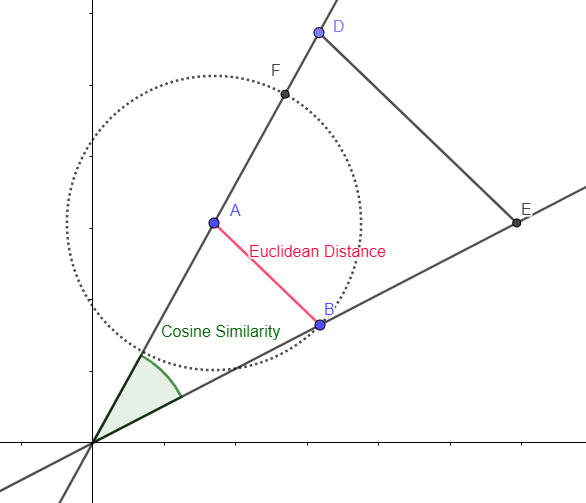

Let's create a function that finds $k$ similair movies for a given movie.

In [31]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):
    """
    Finds k-nearest neighbours for a given movie id.

    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations

    Returns:
        list of k similar movie ID's
    """
    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

We can test out our function by passing in a `movieId`. We'll create a dictionary that maps `movieId` to movie title so that we can better interpret our results.

In this case, `movie_id = 1` is Toy Story. We'll set `k = 10` and use our default metric, `cosine similarity`. This means that we're looking for the 10 most similar movies to Toy Story.

In [32]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_ids = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}...")
for i in similar_ids:
    print(movie_titles[i])

Because you watched Toy Story (1995)...
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)
Back to the Future (1985)


Let's repeat the process but this time using Euclidean distance.

In [33]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1
similar_ids = find_similar_movies(movie_id, X, k=10, metric="euclidean")

movie_title = movie_titles[movie_id]
print(f"Because you watched {movie_title}...")
for i in similar_ids:
    print(movie_titles[i])

Because you watched Toy Story (1995)...
Toy Story 2 (1999)
Mission: Impossible (1996)
Independence Day (a.k.a. ID4) (1996)
Bug's Life, A (1998)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Babe (1995)
Groundhog Day (1993)
Mask, The (1994)
Honey, I Shrunk the Kids (1989)


# Dimensionality Reduction with Matrix Factorization

### (Advanced)

### Matrix Factorization

- A linear algebra technique that can help discover latent features between users and movies
- Latent features give a more compact representation of user tastes and item descriptions
- Can enhance the quality of recommendations when $X$ is very sparse
- Factorizes the user-item matrix into two "factor matrices":
    - user-factor matrix `(n_users, k)`
    - item-factor matrix `(k, n_items)`
    
<img src="images/matrix-factorization.png"/>

### Singular Value Decomposition

- Singular Value Decomposition (SVD) is a type of matrix factorization that is used for data reduction and de-noising
- [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) has a class called `TruncatedSVD` that we can use to reduce our matrix from `(n_users, n_movies)` to `(n_users, n_components)` where `n_components` represents number of latent features.

In [34]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=25, n_iter=10)

Z = svd.fit_transform(X.T)
print(f"The shape of our compressed Z matrix is: {Z.shape}.")

The shape of our compressed Z matrix is: (610, 25).


Let's apply our `find_similar_movies` function to our new Z matrix.

In [35]:
movie_id = 1
similar_movies = find_similar_movies(movie_id, X=Z.T, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Jumanji (1995)
Nixon (1995)
GoldenEye (1995)
Assassins (1995)
Ace Ventura: When Nature Calls (1995)
Cutthroat Island (1995)
Father of the Bride Part II (1995)
Casino (1995)
Powder (1995)
Balto (1995)


When we reduce the dimensions of our original user-item matrix to `(n_users, 30)`, we get the recommendations shown above.

### Top N Recommender

- Matrix factorization allows us to predict missing ratings in our original $X$ matrix
- Reconstruct matrix by getting inner product of the user-factor matrix  and movie-factor matrix

In [36]:
new_X = svd.inverse_transform(Z).T

print(f"Dimensions of original user-item matrix: {X.shape}, {type(X)}")
print(f"Dimensions of SVD-reconstructed X matrix: {new_X.shape}, {type(new_X)}")

Dimensions of original user-item matrix: (9724, 610), <class 'scipy.sparse._csr.csr_matrix'>
Dimensions of SVD-reconstructed X matrix: (9724, 610), <class 'numpy.ndarray'>


Let's try generaing top N recommendations for a user in our dataset. We'll look at `userId` 5. Which movies did this user rate highly?

In [37]:
userId = 5
user_preferences = ratings[(ratings['userId']==userId)&(ratings['rating']>=4)]
user_preferences = user_preferences.merge(movies[['movieId', 'title']])

user_preferences.sort_values('rating', ascending=False).head(5)

,userId,movieId,rating,timestamp,title
11,5,296,5.0,847434748,Pulp Fiction (1994)
8,5,247,5.0,847435337,Heavenly Creatures (1994)
21,5,595,5.0,847434832,Beauty and the Beast (1991)
20,5,594,5.0,847435238,Snow White and the Seven Dwarfs (1937)
19,5,590,5.0,847434747,Dances with Wolves (1990)


<p style="margin-bottom:30;">Now, let's predict which movies userId 5 will also like based on their previous ratings. We need to do the following:</p>

- get row from $X$ which represents userId=5
- sort their predicted ratings in descending order

We can use `np.argsort()` to grab top $N$ indices for `userId=5`.

In [38]:
top_N = 10

movie_titles = dict(zip(movies['movieId'], movies['title']))

top_N_indices = new_X[user_mapper[userId]].argsort()[-top_N:][::-1]

print(f"Top {top_N} Recommendations for UserId {userId}:")
for i in top_N_indices:
    movie_id = movie_inv_mapper[i]
    print(movie_titles[movie_id])

Top 10 Recommendations for UserId 5:
Puppet Masters, The (1994)
Heat (1995)
Beautiful Girls (1996)
Chasers (1994)
Timecop (1994)
Little Women (1994)
Birdcage, The (1996)
Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
Sliver (1993)
In the Name of the Father (1993)
